In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data
gen = pd.read_excel("../data/flambeau_generation.xlsx")
gauge = pd.read_excel("../data/gauge_height.xlsx")
weather = pd.read_excel("../data/weather.xlsx")

# peak at each
print("Power Generation: ")
print(gen.head(), "\n")
print(gen.info(), "\n")
print("Gauge Height: ")
print(gauge.head(), "\n")
print(gauge.info(), "\n")
print("Weather: ")
print(weather.head(), "\n")
print(weather.info(), "\n")

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# replace missing markers
weather.replace(["M", " ", ""], pd.NA, inplace=True)
weather.replace("T", 0, inplace=True)

# convert columns to numeric
numeric_cols = ["High temperature", "Low temperature", "Precipitation", "Snow", "Snow depth"]
for col in numeric_cols:
    weather[col] = pd.to_numeric(weather[col], errors="coerce")


gen["Timestamp"] = pd.to_datetime(gen["Timestamp"]).dt.tz_localize(None).dt.floor("D")
gauge["Timestamp"] = pd.to_datetime(gauge["Timestamp"])
weather.rename(columns={"Date": "Timestamp"}, inplace=True)
weather["Timestamp"] = pd.to_datetime(weather["Timestamp"])

In [ ]:
# Merge data
df = gen.merge(gauge, on="Timestamp", how="inner")
df = df.merge(weather, on="Timestamp", how="inner")

df.ffill(inplace=True)
df.bfill(inplace=True)


df.info()
df.head()

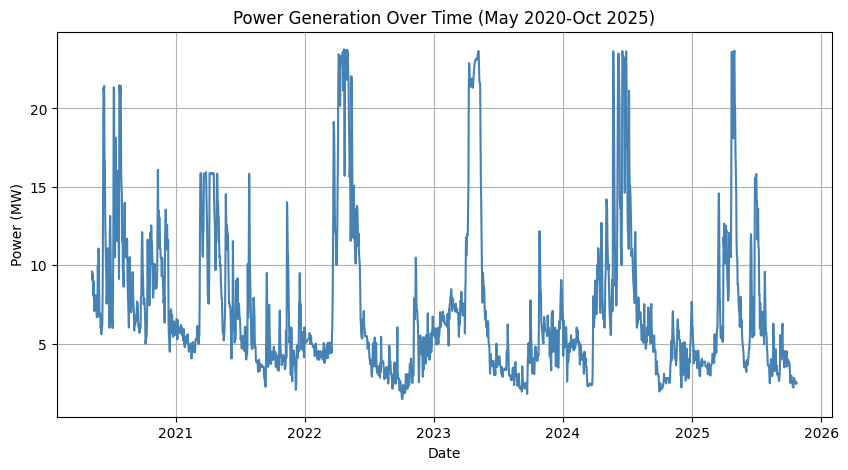

In [ ]:
# Trend over time (line chart)

plt.figure(figsize=(10,5))
plt.plot(df["Timestamp"], df["Flambeau (MW)"], color='steelblue')
plt.title("Power Generation Over Time (May 2020-Oct 2025)")
plt.xlabel("Date")
plt.ylabel("Power (MW)")
plt.grid(True)
plt.show()

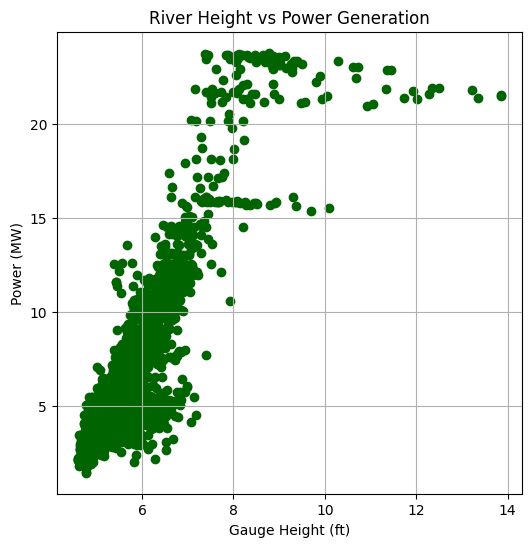

In [ ]:
# Relationship between river height and power

plt.figure(figsize=(6,6))
plt.scatter(df["gauge_height"], df["Flambeau (MW)"], color='darkgreen')
plt.title("River Height vs Power Generation")
plt.xlabel("Gauge Height (ft)")
plt.ylabel("Power (MW)")
plt.grid(True)
plt.show()

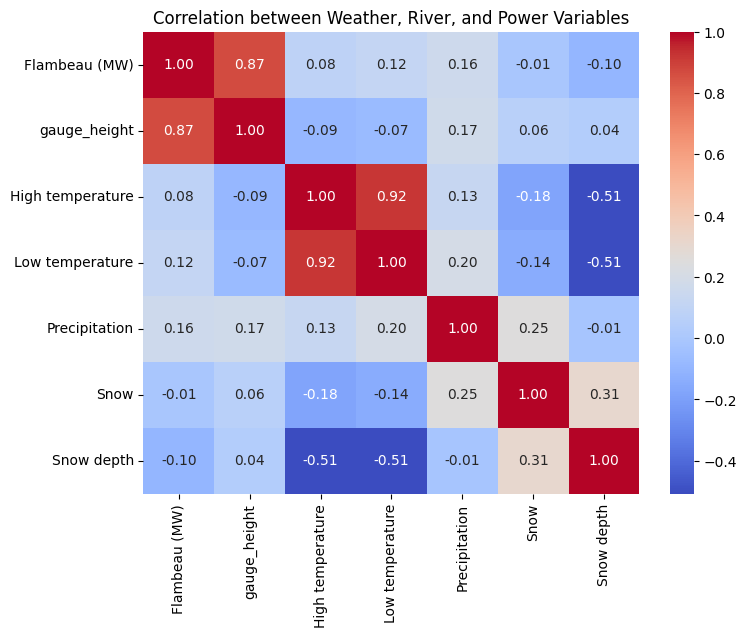

In [ ]:
# Correlation heatmap

plt.figure(figsize=(8,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Weather, River, and Power Variables")
plt.show()

In [ ]:
# Make the predictive model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

features = ["gauge_height", "Precipitation", "Snow", "Snow depth", "High temperature", "Low temperature"]

target = "Flambeau (MW)"

X = df[features]
y = df[target]

# 80 20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# Model 1: Linear regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

print("Linear Regression:")
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("R2:", r2_score(y_test, y_pred_lin))

Linear Regression:
MAE: 1.5010968625716408
R2: 0.8050929767037631


In [ ]:
# Model 2: Random Forest Regressor (Nonlinear)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest: ")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R2:", r2_score(y_test, y_pred_rf))

Random Forest: 
MAE: 1.1469115057421384
R2: 0.8854461024119987


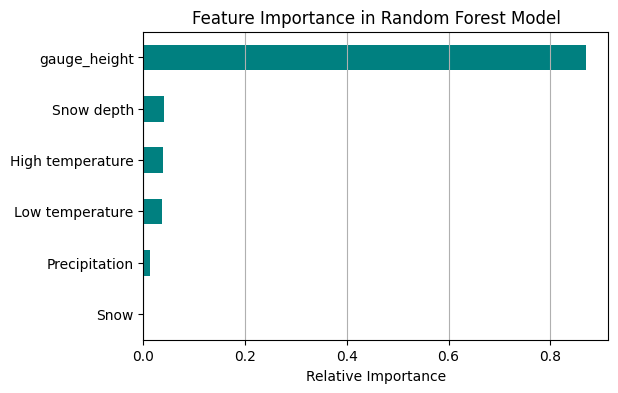

gauge_height        0.870861
Snow depth          0.040509
High temperature    0.037989
Low temperature     0.036572
Precipitation       0.013497
Snow                0.000572
dtype: float64


In [ ]:
# Feature importance analysis


# Get importance values and sort them
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=features).sort_values(ascending=True)

# Plot
plt.figure(figsize=(6,4))
feat_importances.plot(kind='barh', color='teal')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Relative Importance')
plt.grid(True, axis='x')
plt.show()

# print numeric values
print(feat_importances.sort_values(ascending=False))

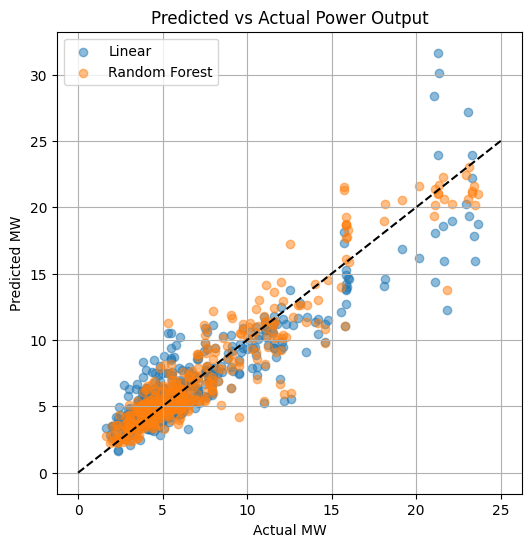

In [ ]:
# Compare visually

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lin, alpha=0.5, label="Linear")
plt.scatter(y_test, y_pred_rf, alpha=0.5, label="Random Forest")
plt.plot([0,25],[0,25],'k--')
plt.xlabel("Actual MW")
plt.ylabel("Predicted MW")
plt.legend()
plt.title("Predicted vs Actual Power Output")
plt.grid(True)
plt.show()

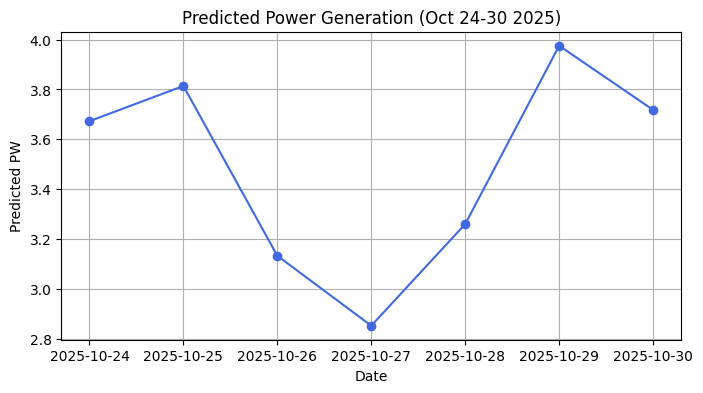

In [ ]:
# Predict future (10/24/2025-10/30/2025)
future = gauge.merge(weather, on="Timestamp", how="inner")

future = future[(future["Timestamp"] >= "2025-10-24") &
                (future["Timestamp"] <= "2025-10-30")]

future_X = future[features]
future["Predicted_MW"] = rf_model.predict(future_X)

# Visualize forecast
plt.figure(figsize=(8,4))
plt.plot(future["Timestamp"], future["Predicted_MW"], marker="o", color="royalblue")
plt.title("Predicted Power Generation (Oct 24-30 2025)")
plt.xlabel("Date")
plt.ylabel("Predicted PW")
plt.grid(True)
plt.show()

<Figure size 800x400 with 0 Axes>

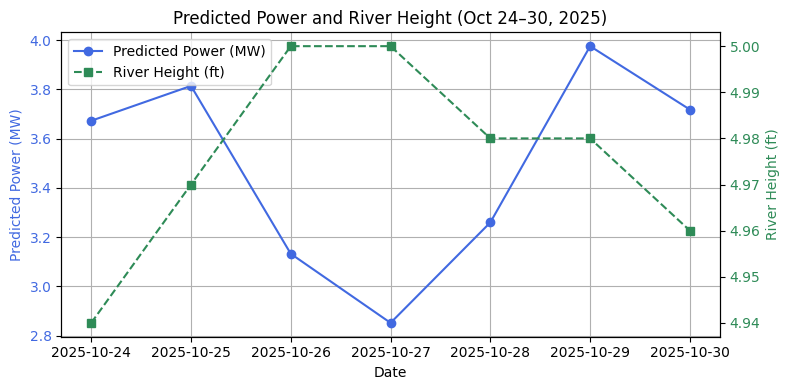

In [ ]:
plt.figure(figsize=(8,4))

# Plot predicted power (left y-axis)
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(future["Timestamp"], future["Predicted_MW"], marker="o", color="royalblue", label="Predicted Power (MW)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Predicted Power (MW)", color="royalblue")
ax1.tick_params(axis="y", labelcolor="royalblue")

# Add river height on a secondary axis (right y-axis)
ax2 = ax1.twinx()
ax2.plot(future["Timestamp"], future["gauge_height"], marker="s", color="seagreen", linestyle="--", label="River Height (ft)")
ax2.set_ylabel("River Height (ft)", color="seagreen")
ax2.tick_params(axis="y", labelcolor="seagreen")

# Title and grid
plt.title("Predicted Power and River Height (Oct 24–30, 2025)")
ax1.grid(True)

# Optional: combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()
